## Imports

In [1]:
import torchvision
import torch
from torchvision import transforms

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

## ETL

In [2]:
dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transforms.ToTensor())
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [40000, 10000])

Files already downloaded and verified
Files already downloaded and verified


In [3]:
batch_size = 256
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

In [4]:
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

## Model utils

In [5]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm

In [6]:
def positivate(net, classes, exceptions):
    if not isinstance(classes, tuple):
        classes = tuple(classes)
    for module in net.children():
        if isinstance(module, classes) and module not in exceptions:
            for param in module.parameters():
                torch.nn.functional.relu(param.data, inplace=True)
        positivate(module, classes, exceptions)

In [7]:
def explore(net, modules=None):
    if modules is None:
        modules = set()
    for module in net.children():
        modules.add(module.__class__)
        explore(module, modules)
    return modules

In [8]:
model = torchvision.models.resnet18()
explore(model)

{torch.nn.modules.activation.ReLU,
 torch.nn.modules.batchnorm.BatchNorm2d,
 torch.nn.modules.container.Sequential,
 torch.nn.modules.conv.Conv2d,
 torch.nn.modules.linear.Linear,
 torch.nn.modules.pooling.AdaptiveAvgPool2d,
 torch.nn.modules.pooling.MaxPool2d,
 torchvision.models.resnet.BasicBlock}

In [9]:
positivate(model, [torch.nn.modules.conv.Conv2d, torch.nn.modules.linear.Linear], [model.fc, model.conv1])

In [10]:
for param in model.layer1.parameters():
    print((param < 0).sum())

tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


In [11]:
for param in model.conv1.parameters():
    print((param < 0).sum())

tensor(4680)


## Training

In [12]:
import time
import numpy as np
from IPython.display import clear_output

def train(model, num_epochs=100, make_convex=False, weight_decay=0):
    if make_convex:
        positivate(model, [torch.nn.modules.conv.Conv2d, torch.nn.modules.linear.Linear], [model.fc, model.conv1])
    opt = torch.optim.Adam(model.parameters())

    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
    
    global_metrics = [[], [], [], []]

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train(True)
        for (X_batch, y_batch) in tqdm(train_batch_gen):
            X_batch = Variable(torch.FloatTensor(X_batch)).cuda()
            y_batch = Variable(torch.LongTensor(y_batch)).cuda()
            logits = model.cuda()(X_batch)
            loss = F.cross_entropy(logits, y_batch).mean()
            
            for param in model.parameters():
                loss += weight_decay * torch.norm(param, 1)
            loss.backward()
            opt.step()
            
            if make_convex:
                positivate(model, [torch.nn.modules.conv.Conv2d, torch.nn.modules.linear.Linear], [model.fc, model.conv1])
            
            opt.zero_grad()
            y_pred = logits.max(1)[1].data
            train_loss.append(loss.cpu().data.numpy())
            train_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

        model.train(False)
        for X_batch, y_batch in val_batch_gen:
            logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
            y_batch = Variable(torch.LongTensor(y_batch)).cuda()
            loss = F.cross_entropy(logits, y_batch).mean()
            y_pred = logits.max(1)[1].data
            val_loss.append(loss.cpu().data.numpy())
            val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

        clear_output(True)
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        global_metrics[0].append(np.mean(train_loss[-len(train_dataset) // batch_size :]))
        global_metrics[1].append(np.mean(val_loss[-len(val_dataset) // batch_size :]))
        global_metrics[2].append(np.mean(train_accuracy[-len(train_dataset) // batch_size :]) * 100)
        global_metrics[3].append(np.mean(val_accuracy[-len(val_dataset) // batch_size :]) * 100)
        print("  training loss (in-iteration): \t{:.6f}".format(global_metrics[0][-1]))
        print("  validation accuracy: \t\t\t{:.2f} %".format(global_metrics[3][-1]))
        
    return global_metrics


In [14]:
model = torchvision.models.resnet18(num_classes=10)
model_metrics = train(model)

Epoch 100 of 100 took 14.841s
  training loss (in-iteration): 	0.005858
  validation accuracy: 			74.96 %


In [15]:
model_convex = torchvision.models.resnet18(num_classes=10)
model_convex_metrics = train(model_convex, make_convex=True)

Epoch 100 of 100 took 13.976s
  training loss (in-iteration): 	0.128174
  validation accuracy: 			66.40 %


In [16]:
model_l1 = torchvision.models.resnet18(num_classes=10)
model_l1_metrics = train(model_l1, weight_decay=1e-5)

Epoch 100 of 100 took 12.855s
  training loss (in-iteration): 	0.428691
  validation accuracy: 			72.80 %


In [17]:
model_convex_l1 = torchvision.models.resnet18(num_classes=10)
model_convex_l1_metrics = train(model_convex_l1, weight_decay=1e-5, make_convex=True)

Epoch 100 of 100 took 12.671s
  training loss (in-iteration): 	0.268767
  validation accuracy: 			69.42 %


In [24]:
models = [
    'model',
    'model_convex',
    'model_l1',
    'model_convex_l1'
]

for model_name in models:
    checkpoint = {
        'name': model_name.replace('model', 'resnet18'),
        'model': globals()[model_name].state_dict(),
        'metrics': globals()[model_name + '_metrics'] 
    }
    torch.save(checkpoint, checkpoint['name'] + '.pth')

Text(0, 0.5, 'Accuracy')

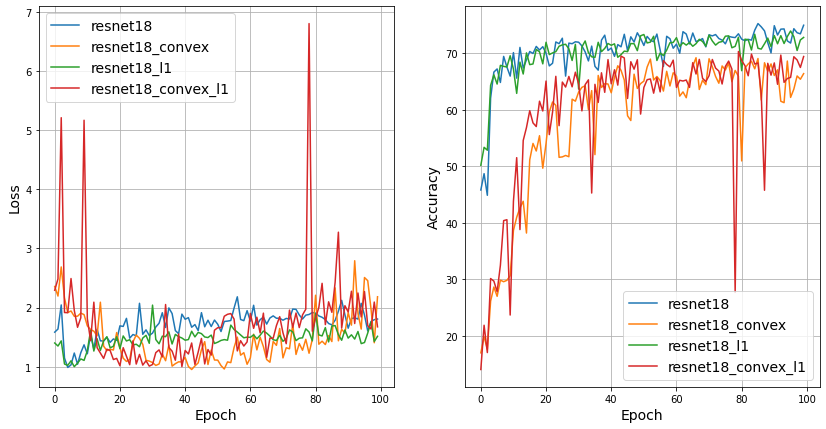

In [25]:
from matplotlib import pyplot as plt

plt.figure(figsize=(14,7))

plt.subplot(1, 2, 1)
plt.grid()
for model_name in models:
    plt.plot(globals()[model_name + '_metrics'][1], label=model_name.replace('model', 'resnet18'))
plt.legend(fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)

plt.subplot(1, 2, 2)
plt.grid()
for model_name in models:
    plt.plot(globals()[model_name + '_metrics'][3], label=model_name.replace('model', 'resnet18'))
plt.legend(fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)

## Sparsity

In [81]:
def calculate_sparsity(net, classes, exceptions, accumulator=None):
    if accumulator is None:
        accumulator = [0, 1]
    if not isinstance(classes, tuple):
        classes = tuple(classes)
    for module in net.children():
        if isinstance(module, classes) and module not in exceptions:
            for param in module.parameters():
                accumulator[0] += torch.sum(param == 0)
                accumulator[1] += np.prod(param.shape)
        calculate_sparsity(module, classes, exceptions, accumulator)
    return accumulator[0] / accumulator[1]

In [82]:
for model_name in models:
    curr_model = globals()[model_name]
    sparsity = calculate_sparsity(curr_model, [torch.nn.modules.conv.Conv2d, torch.nn.modules.linear.Linear],
                                  [curr_model.fc, curr_model.conv1])
    print(f"{model_name.replace('model', 'resnet18')}: {sparsity.item():.03}")

resnet18: 0.0
resnet18_convex: 0.323
resnet18_l1: 0.0
resnet18_convex_l1: 0.954


In [70]:
#model_convex_l1.load_state_dict(torch.load('resnet18_convex_l1.pth')['model'])

<All keys matched successfully>